# 2. Preprocesamiento de texto

En este trabajo se carga un dataset con citas y nombres de distintos autores, realizando luego análisis y preprocesamiento de la información íncluida en este. En primer lugar, se realiza únicamente una tokenización a modo comparativo. Luego, se presentan tres alternativas de preprocesamiento, a saber:

1.   Tokenización, remoción de stopwords, stemming.
2.   Tokenización, remoción de stopwords, inclusión de n-grams, control de frecuencia mínima.
3. Tokenización, remoción de stopwords, stemming, ponderación TF/IDF.

En los primeros dos casos la tokenización y remoción de stopwords se realiza mediante el `CountVectorizer()`, mientras que en el último se realiza la tokenización con el `TfidVectorizer()` y se utiliza el diccionario de stopwords provisto por la biblioteca `ntlk`.

## Carga del dataset

In [11]:
# Carga el archivo desde el almacenamiento local
import pandas as pd
import io

# Obtiene la lista de citas
df_quotes = pd.read_csv('datasets/quotes.txt', sep='\t')
  
# Muestra información de los datos leidos
print("df_quotes:")
print(df_quotes[0:5].to_string())
print(df_quotes.describe())

# Convierte la serie en una lista
li_quotes = df_quotes['Quote'].tolist()
li_quotes[:5]

df_quotes:
            Author                                                                                                                                                                                      Quote
0  Agatha Christie  I like living. I have sometimes been wildly, despairingly, acutely miserable, racked with sorrow; but through it all I still know quite certainly that just to be alive is a grand thing.
1  Agatha Christie                                                                                The impossible could not have happened, therefore the impossible must be possible in spite of appearances. 
2  Agatha Christie                                                                                                       Poirot, I said. I have been thinking. An admirable exercise my friend. Continue it. 
3  Agatha Christie                                                                                                                    Instinct is a marvelous thing. 

['I like living. I have sometimes been wildly, despairingly, acutely miserable, racked with sorrow; but through it all I still know quite certainly that just to be alive is a grand thing.',
 'The impossible could not have happened, therefore the impossible must be possible in spite of appearances. ',
 'Poirot, I said. I have been thinking. An admirable exercise my friend. Continue it. ',
 'Instinct is a marvelous thing. It can neither be explained nor ignored.',
 "The best time for planning a book is while you're doing the dishes. "]

# Preprocesamiento de texto

Como primer paso, se realiza una tokenización de las frases cargadas sin aplicar ningún otro tipo de procesamiento.

Se utiliza para esto el `CountVectorizer()`, mostrando luego los resultados de este proceso.

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
tokens = vectorizer.fit_transform(li_quotes)
features = vectorizer.get_feature_names()

df_tokens = pd.DataFrame(tokens.toarray(), columns=features)

print(f'Se obtienen {len(features)} tokens únicos' + 
      f', siendo el más frecuente "{df_tokens.sum().idxmax()}"' +
       f' con {df_tokens.sum().max()} repeticiones.')

Se obtienen 459 tokens únicos, siendo el más frecuente "the" con 51 repeticiones.


Realizamos a continuación un gráfico con la frecuencia de repetición de las palabras más comunes.

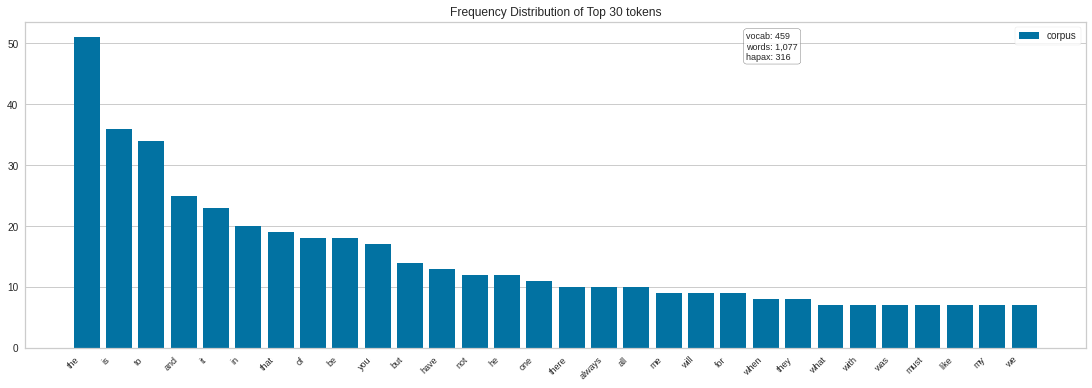

In [20]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (19,6)

from yellowbrick.text import FreqDistVisualizer

visualizer = FreqDistVisualizer(features=features, n=min(30,len(features)), orient='v')
visualizer.fit(tokens)
visualizer.ax.tick_params(axis='x', labelrotation=45, labelsize=9)
visualizer.poof()

## Alternativa \#1

Como es de esperarse, las palabras más frecuentes corresponden a stopwords. Por esto, se realiza la remoción de las mismas con el diccionario provisto por `scikit-learn`, y repite el gráfico previo con el resultado de la operación.

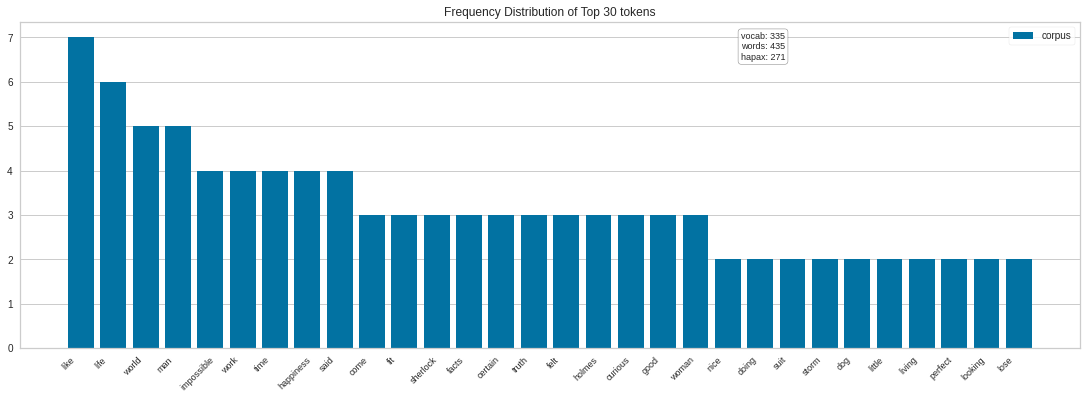

Se disminuye la cantidad de tokens únicos a 335 elementos.


In [21]:
vectorizer = CountVectorizer(stop_words='english')
tokens = vectorizer.fit_transform(li_quotes)
features = vectorizer.get_feature_names()

visualizer = FreqDistVisualizer(features=features, n=min(30,len(features)), orient='v')
visualizer.fit(tokens)
visualizer.ax.tick_params(axis='x', labelrotation=45, labelsize=9)
visualizer.poof()

print(f'Se disminuye la cantidad de tokens únicos a {len(features)} elementos.')

Con esto se logra disminuir la cantidad de tokens o palabras únicas, a la vez que se evidencia en estas una frecuencia menor de aparición.

Como último paso en esta alternativa de procesamiento, se desea realizar el proceso de stemming. 

In [22]:
prev_features = features # Guardamos los features previos para comparar

from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

# Definimos un analyzer y le sumamos una función para el stemming
analyzer = CountVectorizer(stop_words='english').build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

vectorizer = CountVectorizer(analyzer=stemmed_words)
tokens = vectorizer.fit_transform(li_quotes)
features = vectorizer.get_feature_names()

print('En la última etapa se modificaron o eliminaron' +
      f' {len(set(prev_features).difference(set(features)))} tokens.')

En la última etapa se modificaron o eliminaron 179 tokens.


In [23]:
df_tokens_1 = pd.DataFrame(tokens.toarray(), columns=features)

print(f'Se obtienen {len(features)} tokens únicos' + 
      f', siendo el más frecuente "{df_tokens_1.sum().idxmax()}"' +
       f' con {df_tokens_1.sum().max()} repeticiones.')

Se obtienen 318 tokens únicos, siendo el más frecuente "like" con 8 repeticiones.


## Alternativa \#2

En este caso, se le agrega a la tokenización con `CountVectorizer` realizada, la distinción de n-grams (para un n máximo de 2) además de la remoción de stopwords.

In [24]:
vectorizer = CountVectorizer(stop_words='english', analyzer='word', ngram_range=(1, 2))
tokens = vectorizer.fit_transform(li_quotes)
features = vectorizer.get_feature_names()

double = [f for f in features if ' ' in f]
print(f'Se generaron {len(features)} tokens, de los cuales' + 
      f' {len(double)} están compuestos por dos palabras.')

Se generaron 715 tokens, de los cuales 380 están compuestos por dos palabras.


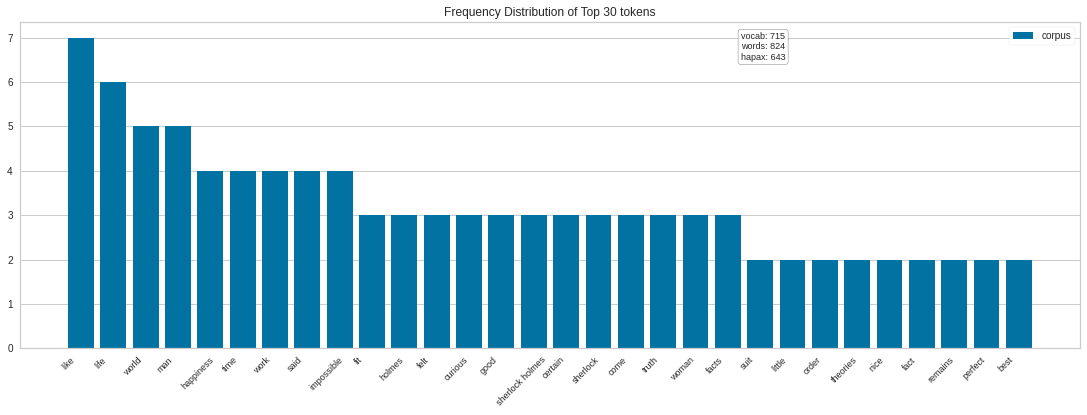

In [25]:
visualizer = FreqDistVisualizer(features=features, n=min(30,len(features)), orient='v')
visualizer.fit(tokens)
visualizer.ax.tick_params(axis='x', labelrotation=45, labelsize=9)
visualizer.poof()

De los 380 tokens generados de dos palabras, vemos que una pequeña cantidad aparece entre los tokens más repetidos.

Adicionalmente, se decide realizar un control de frecuencia mínima, conservando los tokens que aparecen en dos de los documentos de entrada.

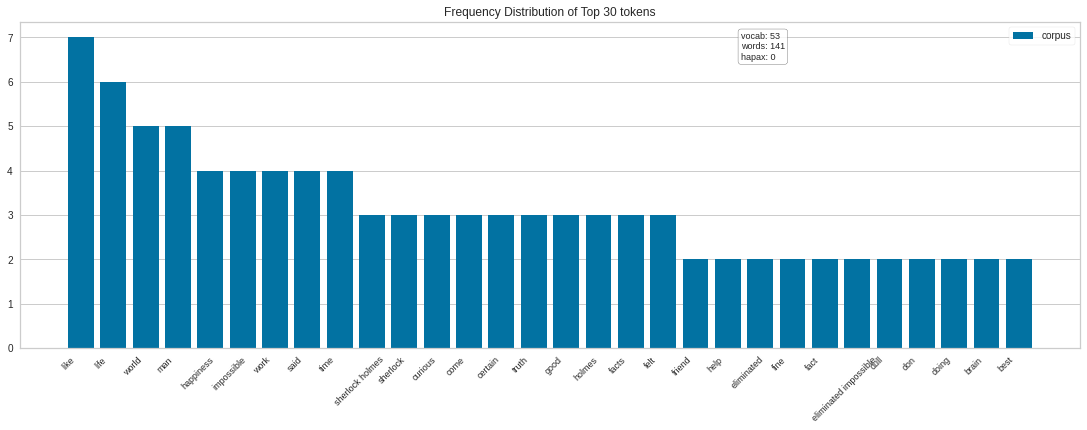

Se conservan 5 tokens compuestos por dos palabras.


In [26]:
vectorizer = CountVectorizer(stop_words='english', analyzer='word',
                             ngram_range=(1, 2), min_df=2)
tokens = vectorizer.fit_transform(li_quotes)
features = vectorizer.get_feature_names()

visualizer = FreqDistVisualizer(features=features, n=min(30,len(features)), orient='v')
visualizer.fit(tokens)
visualizer.ax.tick_params(axis='x', labelrotation=45, labelsize=9)
visualizer.poof()

double = [f for f in features if ' ' in f]
print(f'Se conservan {len(double)} tokens compuestos por dos palabras.')

In [27]:
df_tokens_2 = pd.DataFrame(tokens.toarray(), columns=features)

print(f'Se obtienen {len(features)} tokens únicos' + 
      f', siendo el más frecuente "{df_tokens_2.sum().idxmax()}"' +
       f' con {df_tokens_2.sum().max()} repeticiones.')

Se obtienen 53 tokens únicos, siendo el más frecuente "like" con 7 repeticiones.


## Alternativa \#3

Por último, agregamos al procesamiento realizado en la primer alternativa, una normalización TF/IDF. En este caso, la tokenización se realiza directamente con el `TfidfVectorizer`, y se utiliza el diccionario de stopwords de `nltk`.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


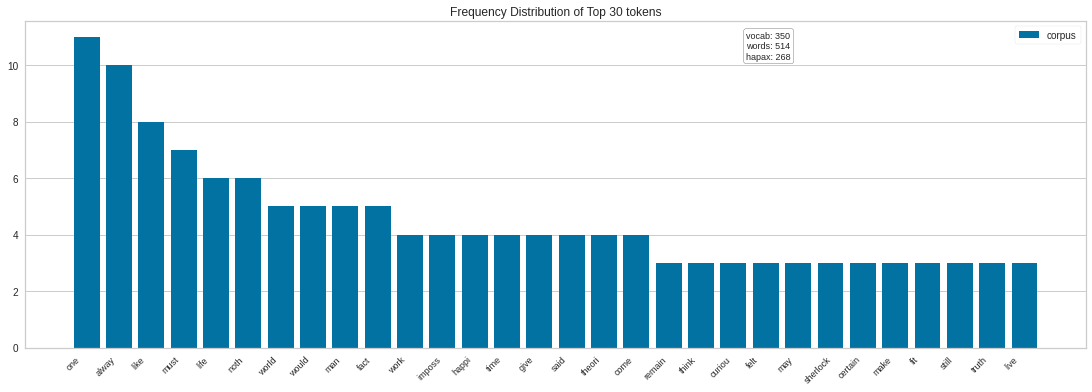

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
stop_ws = nltk.corpus.stopwords.words('english')

# Construimos un nuevo analyzer
analyzer = TfidfVectorizer(stop_words=stop_ws).build_analyzer()

# Aplicamos tokenización, y stemming con la función definida previamente
vectorizer = TfidfVectorizer(analyzer=stemmed_words) 
tokens = vectorizer.fit_transform(li_quotes)
features = vectorizer.get_feature_names()

# Realizamos mismo procesamiento sin TF/IDF para graficar
vec_plot = CountVectorizer(analyzer=stemmed_words)

visualizer = FreqDistVisualizer(features=features, n=min(30,len(features)), orient='v')
visualizer.fit(vec_plot.fit_transform(li_quotes))
visualizer.ax.tick_params(axis='x', labelrotation=45, labelsize=9)
visualizer.poof()

In [29]:
df_tokens_3 = pd.DataFrame(tokens.toarray(), columns=features)

print(f'Se obtienen {len(features)} tokens únicos' + 
      f', siendo el de mayor valor relativo "{df_tokens_3.max().idxmax()}"' +
       f' con un valor de {df_tokens_3.max().round(4).max()}.')

Se obtienen 350 tokens únicos, siendo el de mayor valor relativo "observ" con un valor de 0.7071.


# Comparación entre los resultados obtenidos

In [34]:
print('La cantidad de tokens obtenidos en cada alternativa de preprocesamiento son:' +
      f'\n {df_tokens_1.shape[1]} tokens en la primer alternativa, ' +
      f'{df_tokens_2.shape[1]} en la segunda, y {df_tokens_3.shape[1]} en la tercera.')

La cantidad de tokens obtenidos en cada alternativa de preprocesamiento son:
 318 tokens en la primer alternativa, 53 en la segunda, y 350 en la tercera.


Como puede verse, el proceso de control de frecuencia mínima produce una reducción notable de la cantidad de tokens obtenidos.

Para finalizar, se realiza una breve comparación, entre las tres alternativas ejecutadas, de dos de las frases analizadas.

In [0]:
def get_nz(df_tokens, row=0):
  return pd.DataFrame(df_tokens.loc[row][df_tokens.loc[row] != 0])

def comp(row=0):
  a = get_nz(df_tokens_1, row)
  b = get_nz(df_tokens_2, row)
  c = get_nz(df_tokens_3, row)
  return pd.concat([a, b, c], axis=1, keys=['#1', '#2', '#3']).fillna(0)

In [55]:
print(df_quotes.loc[5,'Author'])
print(df_quotes.loc[5,'Quote'])
comp(5)

Agatha Christie
You gave too much rein to your imagination. Imagination is a good servant, and a bad master. The simplest explanation is always the most likely.


,#1,#2,#3
,5,5,5
bad,1.0,0.0,0.272076
explan,1.0,0.0,0.272076
gave,1.0,0.0,0.272076
good,1.0,1.0,0.226710
imagin,2.0,0.0,0.544152
like,1.0,0.0,0.173634
master,1.0,0.0,0.272076
rein,1.0,0.0,0.272076
servant,1.0,0.0,0.272076


En la segunda alternativa se conserva únicamente la palabra *'good'* dado el control de frecuencia mínima. Se observa que la ponderación TF/IDF asigna el valor relativo más alto al token *'imagin'*. Adicionalmente, vemos la diferencia generado al utilizar dos diccionarios de stopwords distintos, dado que *'alway'* y *'much'* no están incluídos en el de `ntlk`.

In [52]:
'always' in stop_ws, 'much' in stop_ws

(False, False)

In [54]:
print(df_quotes.loc[35,'Author'])
print(df_quotes.loc[35,'Quote'])
comp(35)

Arthur Conan Doyle
It is a capital mistake to theorize before one has data. Insensibly one begins to twist facts to suit theories, instead of theories to suit facts.


,#1,#2,#3
,35,35,35
begin,1.0,0.0,0.225508
capit,1.0,0.0,0.225508
data,1.0,0.0,0.225508
fact,2.0,0.0,0.375813
insens,1.0,0.0,0.225508
instead,1.0,0.0,0.225508
mistak,1.0,0.0,0.225508
suit,2.0,0.0,0.451017
theori,2.0,0.0,0.407025


Similarmente, se conserva un único token, *'facts'*, en la segunda alternativa. Este por el proceso de stemming se convierte a *'fact'* en las otras dos. Para el análisis por TF/IDF, *'suit'* obtiene el máximo valor relativo.